In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
import torch
import nci
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from models import AffinityModel
from sklearn.model_selection import train_test_split

In [64]:
path_model = './out/best.pth'
path_aevc = './out/aevc.pth'
model = utils.loadmodel(path=path_model)
AEVC = utils.loadAEVC(path=path_aevc)

In [145]:
model

AffinityModel(
  (0): AtomicNN(
    (layers): ModuleList(
      (0): Linear(in_features=384, out_features=80, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=80, out_features=60, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=60, out_features=40, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.5, inplace=False)
      (9): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (1): AtomicNN(
    (layers): ModuleList(
      (0): Linear(in_features=384, out_features=80, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=80, out_features=60, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=60, out_features=40, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.5, inplace=False)
      (9): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (2): AtomicNN(
    (layers)

In [65]:
df = nci.load_dfs(datasets=['NCIA_HB375x10'], exclude=True)
df['energies'] = df.energies.astype('float')
data = nci.df_to_data(df)

In [66]:
_, labels, species_coordinates_ligmasks, index_diff = iter(dataloader).next()

In [67]:
species = species_coordinates_ligmasks[0]
coordinates = species_coordinates_ligmasks[1]

In [68]:
aevs = AEVC.forward((species, coordinates), index_diff).aevs

In [69]:
aevs.shape

torch.Size([1, 15, 384])

In [70]:
dft = pd.DataFrame(np.loadtxt('./out/loss.dat'), columns=['Training', 'Validation'])

In [74]:
dft = np.sqrt(dft)

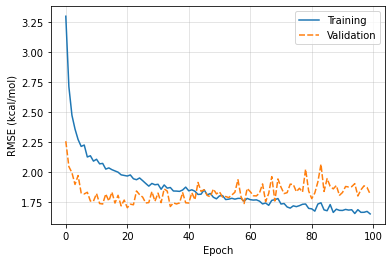

In [124]:
sns.lineplot(data=dft)
plt.ylabel('RMSE (kcal/mol)')
plt.xlabel('Epoch')
plt.grid(alpha=0.4)
plt.savefig('images/tv.png', dpi=300)

In [150]:
dft.Validation.min()

1.703837727015105

In [59]:
training, validation, n_species = nci.load_hb_w_split()
device = torch.devaice("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
df = nci.load_dfs(datasets=['NCIA_HB375x10'], exclude=True)
df['energies'] = df.energies.astype('float')

In [96]:
validloader = nci.get_data_loader(validation, batch_size=1, shuffle=False)

In [97]:
ids, true, preds = nci.get_predictions(validloader, model, AEVC, device)
dfp = df.loc[df.id.isin(ids[:, 1].astype('int'))]
dfp.loc[:, 'pred'] = preds
dfp['sq_error'] = np.square(dfp.pred - dfp.energies)

/var/folders/rd/64lt4yfn7y3ch2mm0wl6g3vw0000gn/T/ipykernel_71468/3850491940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp.loc[:, 'pred'] = preds
/var/folders/rd/64lt4yfn7y3ch2mm0wl6g3vw0000gn/T/ipykernel_71468/3850491940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['sq_error'] = np.square(dfp.pred - dfp.energies)


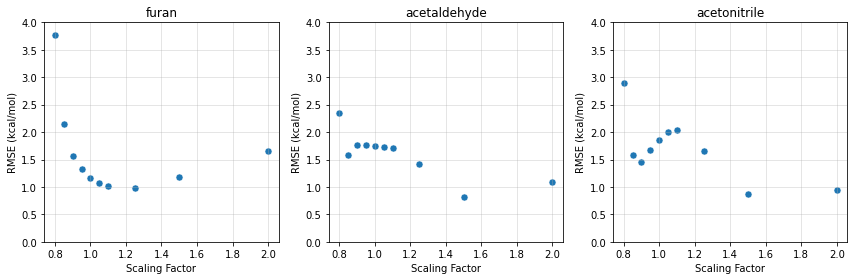

In [183]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, molecule in enumerate(nci.dataset_exclude['NCIA_HB375x10']):
    df_molcule = dfp.loc[(dfp.MoleculeA == molecule) | (dfp.MoleculeB == molecule)]
    ax = axs.ravel()[i]
    sns.scatterplot(ax=ax, s=50, data=np.sqrt(df_molcule.groupby('scaling').sq_error.mean()))
    ax.set_xlabel('Scaling Factor')
    ax.set_ylabel('RMSE (kcal/mol)')
    ax.set_ylim(0, 4)
    ax.grid(alpha=0.4)
    ax.set_title(molecule)
plt.tight_layout()
plt.savefig('images/molecules_rmse.png', dpi=300)

<Figure size 432x432 with 0 Axes>

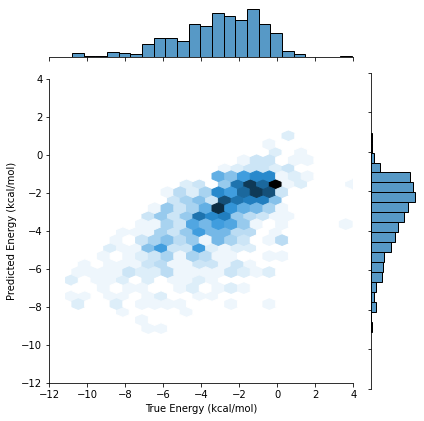

In [161]:
plt.figure(figsize=(6, 6))
sns.jointplot(x='energies', y='pred', data=dfp, kind='hex')
plt.xlabel('True Energy (kcal/mol)')
plt.ylabel('Predicted Energy (kcal/mol)')
plt.xlim((-12, 4))
plt.ylim((-12, 4))
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('images/hexbin_pred.png', dpi=300)

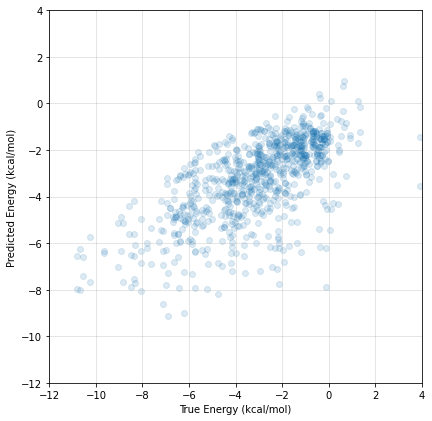

In [162]:
plt.figure(figsize=(6, 6))
plt.scatter(true, preds, alpha=0.15)
plt.xlabel('True Energy (kcal/mol)')
plt.ylabel('Predicted Energy (kcal/mol)')
plt.xlim((-12, 4))
plt.ylim((-12, 4))
plt.grid(alpha=0.4)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('images/scatter_pred.png', dpi=300)

In [111]:
np.corrcoef(true, preds)[0][1], np.sqrt(np.mean(np.square(true - preds)))

(0.6621839863477927, 1.736001171536776)

In [174]:
', '.join(list(set(dfp.MoleculeA.unique()) - set(nci.dataset_exclude['NCIA_HB375x10'])))

'ethene, acetic acid, dimethylamine, methane, methanol, 1H-pyrrole, phenol, benzene, ethyne, aniline, N-methylacetamide, ammonia, methylamine, water'

In [170]:
dfp.shape 

(840, 18)

In [171]:
840 / 20

42.0

In [10]:
dataloader = nci.get_data_loader(nci.df_to_data(df), batch_size=1, shuffle=False)

In [116]:
identifiers_gen, true_gen, predictions_gen = nci.get_predictions(validloader, model, AEVC, device)

In [105]:
pair1_gen = predictions_gen[::2]
pair2_gen = predictions_gen[1::2]

<Figure size 432x432 with 0 Axes>

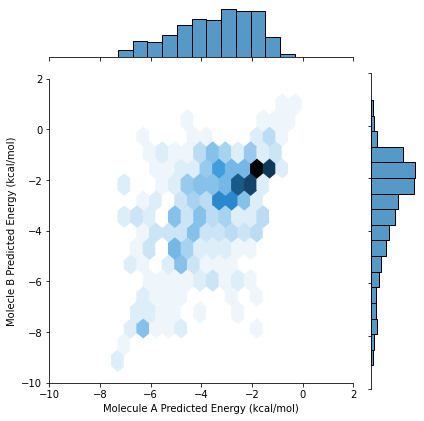

In [163]:
plt.figure(figsize=(6, 6))
sns.jointplot(x=pair1_gen, y=pair2_gen, kind='hex')
plt.xlabel('Molecule A Predicted Energy (kcal/mol)')
plt.ylabel('Molecle B Predicted Energy (kcal/mol)')
plt.xlim((-10, 2))
plt.ylim((-10, 2))
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('images/left_right.png', dpi=300)

In [166]:
dfp

,MoleculeA,MoleculeB,interaction_type,interaction,species,coordinates,index_diff,energies,scaling,reverse,O,N,C,H,id,dataset,pred,sq_error
0,acetic acid,acetaldehyde,HB,OH-O,"[tensor(1), tensor(3), tensor(3), tensor(0), t...","[[tensor(-1.6767), tensor(-0.1555), tensor(0.)...",8,-4.591,0.80,False,3,0,4,8,0,NCIA_HB375x10,-5.917902,1.760670
1,acetaldehyde,acetic acid,HB,OH-O,"[tensor(3), tensor(1), tensor(1), tensor(0), t...","[[tensor(1.2065), tensor(0.9555), tensor(0.)],...",7,-4.591,0.80,True,3,0,4,8,0,NCIA_HB375x10,-6.964397,5.633013
2,acetic acid,acetaldehyde,HB,OH-O,"[tensor(1), tensor(3), tensor(3), tensor(0), t...","[[tensor(-1.6767), tensor(-0.1555), tensor(0.)...",8,-7.802,0.85,False,3,0,4,8,1,NCIA_HB375x10,-6.192664,2.589963
3,acetaldehyde,acetic acid,HB,OH-O,"[tensor(3), tensor(1), tensor(1), tensor(0), t...","[[tensor(1.2935), tensor(0.9504), tensor(0.)],...",7,-7.802,0.85,True,3,0,4,8,1,NCIA_HB375x10,-5.985387,3.300083
4,acetic acid,acetaldehyde,HB,OH-O,"[tensor(1), tensor(3), tensor(3), tensor(0), t...","[[tensor(-1.6767), tensor(-0.1555), tensor(0.)...",8,-9.642,0.90,False,3,0,4,8,2,NCIA_HB375x10,-6.437030,10.271831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,furan,N-methylacetamide,VDW,VDW,"[tensor(1), tensor(3), tensor(1), tensor(1), t...","[[tensor(-2.2860), tensor(-0.3511), tensor(1.2...",9,-2.984,1.25,True,2,1,7,11,3727,NCIA_HB375x10,-2.768311,0.046522
7456,N-methylacetamide,furan,VDW,VDW,"[tensor(1), tensor(0), tensor(0), tensor(0), t...","[[tensor(1.7711), tensor(-1.7755), tensor(-0.4...",12,-1.592,1.50,False,2,1,7,11,3728,NCIA_HB375x10,-2.999368,1.980684
7457,furan,N-methylacetamide,VDW,VDW,"[tensor(1), tensor(3), tensor(1), tensor(1), t...","[[tensor(-2.9394), tensor(-0.3878), tensor(1.3...",9,-1.592,1.50,True,2,1,7,11,3728,NCIA_HB375x10,-2.449598,0.735474
7458,N-methylacetamide,furan,VDW,VDW,"[tensor(1), tensor(0), tensor(0), tensor(0), t...","[[tensor(1.7711), tensor(-1.7755), tensor(-0.4...",12,-0.534,2.00,False,2,1,7,11,3729,NCIA_HB375x10,-2.468811,3.743492


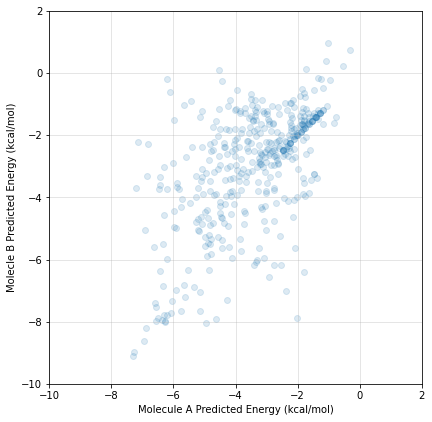

In [165]:
plt.figure(figsize=(6, 6))
plt.scatter(pair1_gen, pair2_gen, alpha=0.15)
plt.xlabel('Molecule A Predicted Energy (kcal/mol)')
plt.ylabel('Molecle B Predicted Energy (kcal/mol)')
plt.xlim((-10, 2))
plt.ylim((-10, 2))
plt.grid(alpha=0.4)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('images/scatter_left_right.png', dpi=300)

<Figure size 432x432 with 0 Axes>

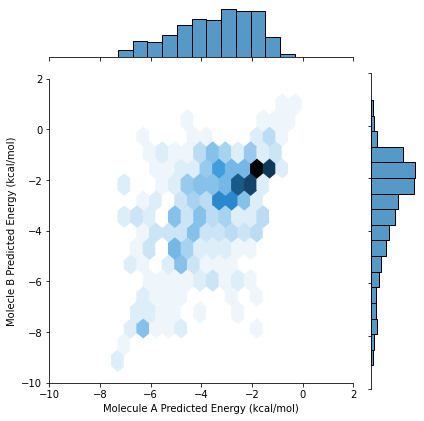

In [167]:
plt.figure(figsize=(6, 6))
sns.jointplot(x=pair1_gen, y=pair2_gen, kind='hex')
plt.xlabel('Molecule A Predicted Energy (kcal/mol)')
plt.ylabel('Molecle B Predicted Energy (kcal/mol)')
plt.xlim((-10, 2))
plt.ylim((-10, 2))
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('images/hexbin_left_right.png', dpi=300)

In [112]:
np.corrcoef(pair1_gen, pair2_gen)[0][1], np.sqrt(np.mean(np.square(pair1_gen - pair2_gen)))

(0.5829930964953013, 1.6621197331457216)

In [121]:
f = np.array([0.8, 0.85, 0.90, 0.95, 1.0, 1.05, 1.1, 1.25, 1.5, 2.0])
errors = np.square(predictions_gen - true_gen)
error_stack = np.hstack((errors[::2].reshape(-1, 10), errors[1::2].reshape(-1, 10))).reshape(-1, 2, 10)
f_stack = np.tile(f, 375 * 2).reshape(-1, 2, 10)
error_mean = error_stack.mean(axis=1).mean(axis=0)
error_sd = error_stack.mean(axis=1).std(axis=0)
error_q = np.quantile(error_stack.mean(axis=1), (0.05, 0.95), axis=0)

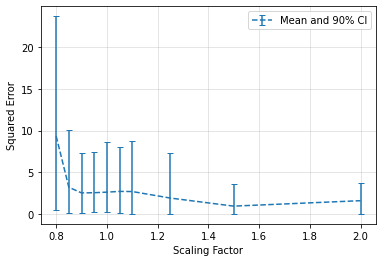

In [123]:
plt.errorbar(f, error_mean, ls='dashed', yerr=np.abs(error_q - error_mean),
            capsize=3, label="Mean and 90% CI")
plt.ylabel("Squared Error")
plt.grid(alpha=0.4)
plt.xlabel("Scaling Factor")
plt.legend()
plt.savefig('images/sq_error_by_scaling.png', dpi=300)
plt.show()

In [146]:
dfp.shape

(840, 18)

In [147]:
df.shape

(7500, 16)

In [148]:
840/7500

0.112

In [129]:
dfp['index_diff'] = dfp.index_diff.astype('int')

/var/folders/rd/64lt4yfn7y3ch2mm0wl6g3vw0000gn/T/ipykernel_71468/3370040125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['index_diff'] = dfp.index_diff.astype('int')


<AxesSubplot:xlabel='index_diff', ylabel='sq_error'>

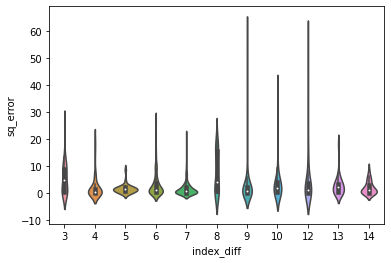

In [133]:
sns.violinplot(x='index_diff', y='sq_error', data=dfp)

In [134]:
np.corrcoef(dfp.index_diff, dfp.sq_error)

array([[1.        , 0.03984004],
       [0.03984004, 1.        ]])

In [137]:
np.corrcoef(dfp.species.map(lambda x: len(x)), dfp.sq_error)

array([[1.        , 0.07996091],
       [0.07996091, 1.        ]])

In [138]:
len(df)

7500

In [139]:
7500 / 2

3750.0

In [140]:
df2 = nci.load_dfs(datasets=['NCIA_HB300SPXx10'], exclude=True)

In [141]:
df2.shape

(6000, 22)